# NYC Motor Vehicle Collisions — Time of Day Analysis (Preliminary Project Update)

**Authors:**
Adan Valadez
Liam O'Herlihy
Tasneem Khokha

**Goal:** Investigate whether *time of day* correlates with crash frequency and severity in NYC.
This analysis-focused notebook includes:
- dataset acquisition (NYC Open Data)
- clear problem statement and target measures
- feature selection (temporal & contextual features)
- preprocessing and cleaning steps
- exploratory data analysis and visualizations focused on time-of-day patterns
- preliminary aggregation and statistical checks 

In [1]:
# Cell 1 — Setup: imports and download parameters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set(style='whitegrid')

SAMPLE_LIMIT = 50000  # set to None to show full dataset
DATA_URL = "https://data.cityofnewyork.us/resource/h9gi-nx95.csv"

print('Notebook ready. SAMPLE_LIMIT =', SAMPLE_LIMIT)

Notebook ready. SAMPLE_LIMIT = 50000


## Problem statement

We will analyze whether **time of day** correlates with the **frequency** and **severity** of motor vehicle collisions in NYC.  
Specifically:

- Primary question (descriptive / inferential): *How does crash frequency vary by hour of the day and day of the week?*  
- Secondary question (severity): *Do crashes occurring at certain hours have higher injury or fatality rates?*  

**Target measures used in this analysis:**

- Crash **count** aggregated by hour / weekday (main descriptive target)
- Injury rate (mean number of persons injured per crash) by hour
- Fatality rate (proportion of crashes with >=1 person killed) by hour

In [ ]:
# Cell 2 — Download / Load the data 
df = pd.read_csv(DATA_URL, nrows=SAMPLE_LIMIT, low_memory=False)
print(df.shape)
print(df.head())

,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,off_street_name,cross_street_name,...,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code1,vehicle_type_code2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5
0,2021-09-11T00:00:00.000,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,2022-03-26T00:00:00.000,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,2023-11-01T00:00:00.000,1:29,BROOKLYN,11230.0,40.62179,-73.970024,"\n, \n(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,2022-06-29T00:00:00.000,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,2022-09-21T00:00:00.000,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


(1000, 29)
Index(['crash_date', 'crash_time', 'borough', 'zip_code', 'latitude',
       'longitude', 'location', 'on_street_name', 'off_street_name',
       'cross_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'contributing_factor_vehicle_1',
       'contributing_factor_vehicle_2', 'contributing_factor_vehicle_3',
       'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5',
       'collision_id', 'vehicle_type_code1', 'vehicle_type_code2',
       'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5'],
      dtype='object')


In [ ]:
# Cell 3 -  Preprocessing & feature engineering (temporal focus)
# Build a proper datetime
date_col = 'crash_date'
time_col = 'crash_time'

dt = pd.to_datetime(
    df[date_col].astype(str) + ' ' + df[time_col].astype(str),
    errors='coerce'
)

# Add hour / weekday
df = df.assign(hour=dt.dt.hour.astype('Int64'), weekday=dt.dt.day_name())

# Counts by hour (0–23)
hour_counts = (
    df.groupby('hour', dropna=True)
      .size()
      .reindex(range(24), fill_value=0)
)
print(hour_counts)

/tmp/ipykernel_15142/3361629214.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CRASH_DATETIME'] = pd.to_datetime(df['crash_date'] + ' ' + df['crash_time'], errors='coerce')


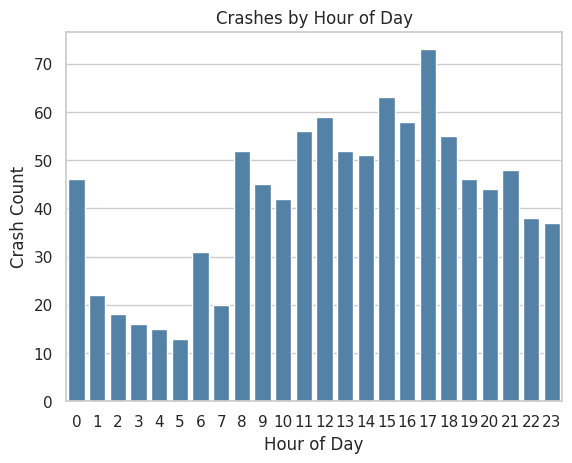

In [ ]:
# Cell 4 Exploratory plots: crash frequency by hour and day of week
# Plot bar
hour_counts.plot(kind="bar")
plt.xlabel("Hour of day (0–23)")
plt.ylabel("Crash count")
plt.title("Crashes by Hour")
plt.show()

#Plot scatter
plt.figure()
plt.scatter(hour_counts.index, hour_counts.values, s=35)
plt.xlabel("Hour of day (0–23)")
plt.ylabel("Crash count")
plt.title("Crashes by Hour (scatter)")
plt.show()

In [5]:
# Cell 5 — Injury and fatality rates by hour
hourly = df.groupby('hour').agg(
    crashes=('hour','count'),
    mean_injuries=('number_of_persons_injured','mean'),
    fatality_rate=('number_of_persons_killed', lambda x: (x>0).mean())
).reset_index()

display(hourly.head())

,hour,crashes,mean_injuries,fatality_rate
0,0,46,0.369565,0.021739
1,1,22,0.272727,0.000000
2,2,18,0.500000,0.000000
3,3,16,0.562500,0.000000
4,4,15,0.266667,0.000000


In [6]:
# Cell 6 — Simple statistical check: are late-night hours riskier?